# Анализ данных датасета

В данном ноутбуке будет рассмотрен датасет (или его честь). [Ссылка на используемый датасет](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop?select=2020-Jan.csv).

Статистика была взята за несколько месяцев (с октября 2019 по февраль 2020 года). Для текущего анализа и обучения модели будут использоваться только данные за декабрь 2019 года. Для экспериментов с кафкой будут взяты данные за январь 2020 года. Модель наверняка будет ошибаться чаще, чем на декабрьском датасете, так как будут разные группы товаров и разные пользователи, поэтому придётся ориентироваться на общему поведению пользователей, а не переобучаться на конкретной группе товаров.

В данном датасете собрана информация о кликах (взаимодействии пользователей) из онлайн магазина, продающего косметику.

Решаемая задача следующая:
- Нужно обучить модель предсказывать вероятность того, что в конкретном `session_id` определённый пользователь `user_id` приобретёт (`event_type` будет иметь значение `purchase`) товар.
- В дальнейшем эта вероятность покупки позволит разбить пользователей на три типа:
  1) Те, кто пришли просто посмотреть товары (вероятность покупки низкая)
  2) Те, кто сомневаются, покупать или нет, но в целом готовы купить (вероятность в районе 50%, но лучше чуть выше)
  3) Те, кто почти наверняка купят то, что хотели.


Именно из-за пользователей из второй группы и приходится проводить полноценный анализ и обучать модели. 
- Этих пользователей можно попробовать стимулировать купить продукт через коротковременную скидку или специальное предложение, которое повысит маржу.
- Для остальных категорий этого делать смысла нет, так как либо промо уйдёт в пустоту, либо же магазин потеряет деньги на том, что предоставил скидку покупателю, который итак мог бы купить товар без скидки.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
import joblib
import os

## Загрузка и первичный анализ датасета

In [2]:
# Загружаем датасет пачками
data_path = 'data/2019-Dec.csv'
partition_size = 400000 # ради экономии памяти берём батч поменьше
# partition_size = None

In [3]:
# Грузим датасет
if partition_size:
	dataset = next(pd.read_csv(data_path, chunksize=partition_size))
else:
	dataset = pd.read_csv(data_path, chunksize=partition_size)
dataset.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     400000 non-null  object 
 1   event_type     400000 non-null  object 
 2   product_id     400000 non-null  int64  
 3   category_id    400000 non-null  int64  
 4   category_code  6860 non-null    object 
 5   brand          227669 non-null  object 
 6   price          400000 non-null  float64
 7   user_id        400000 non-null  int64  
 8   user_session   399903 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 134.0 MB


In [4]:
dataset.head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5
5,2019-12-01 00:00:09 UTC,view,5773361,1487580005134238553,NaN,runail,2.62,560109803,38cf4ba1-4a0a-4c9e-b870-46685d105f95
6,2019-12-01 00:00:18 UTC,cart,5629988,1487580009311764506,NaN,NaN,1.19,579966747,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b
7,2019-12-01 00:00:22 UTC,view,5807805,1487580005713052531,NaN,ingarden,4.44,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5
8,2019-12-01 00:00:27 UTC,view,5588608,1487580008145748965,NaN,roubloff,5.40,546170008,676d9fcc-2a4f-4448-b49d-136f2e4208c1
9,2019-12-01 00:00:34 UTC,cart,5335,1487580009605365797,NaN,runail,0.40,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554


In [5]:
# Считаем процент пропусков в данных
dataset.isna().sum() / dataset.shape[0] * 100

event_time        0.00000
event_type        0.00000
product_id        0.00000
category_id       0.00000
category_code    98.28500
brand            43.08275
price             0.00000
user_id           0.00000
user_session      0.02425
dtype: float64

In [6]:
# Считаем дупликаты
dataset[dataset.duplicated(keep=False)].shape

(42365, 9)

Проверим, есть ли у нас выбросы/баги в данных. Начнём с отрицательной цены за товар.

In [7]:
# Смотрим на вероятные выбросы в данных
display(dataset[dataset["price"] < 0].shape)
display(dataset[dataset["price"] < 0])

(0, 9)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session


Данные странные: они связаны с одной категорией товаров, у них нет бренда и категориального кода, при том все эти товары -- это покупки. Вероятно, либо баг системы, либо промокод на следующую покупку, но в целом как-то описать сложно. Так как данных мало, можно ими пренебречь для стабильности обучения.

Далее следует попробовать изучить случаи с `price` = 0. Нужно попробовать понять, откуда такое большое количество действий с нулевой ценой, с чем они связаны, и можно ли их в дальнейшем убрать для сохранения целостности данных.

In [8]:
# Считаем ошибки в системе (ценник не может быть меньше или равен 0)
dataset[dataset['price'] == 0].shape

(1449, 9)

In [9]:
dataset[dataset['price'] == 0].head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
2586,2019-12-01 01:30:14 UTC,view,5908170,1487580013950664926,NaN,NaN,0.0,579993583,10f5d243-c5a6-4881-8c69-43f64cec9383
2944,2019-12-01 01:49:50 UTC,view,5897797,2195085255034011676,NaN,NaN,0.0,566922379,f3d09cb1-915f-48fc-8749-a83f33e633c1
2971,2019-12-01 01:52:01 UTC,view,5897797,2195085255034011676,NaN,NaN,0.0,566922379,f3d09cb1-915f-48fc-8749-a83f33e633c1
2982,2019-12-01 01:53:00 UTC,view,5897797,2195085255034011676,NaN,NaN,0.0,566922379,43530ca6-3eb1-4f7d-aab6-ebabdae52fe9
3003,2019-12-01 01:55:05 UTC,view,5903915,1487580007675986893,NaN,NaN,0.0,579972058,8c9fb590-38a5-403a-9865-5abd0b09b6c6
4204,2019-12-01 03:08:02 UTC,view,5906721,1814592470537732872,NaN,NaN,0.0,564448710,118411a9-057d-467d-a98f-62ef14a033df
5445,2019-12-01 04:00:17 UTC,view,5904952,1487580009051717646,NaN,NaN,0.0,580032681,b8c4b793-58f2-48f3-aeae-6d3d48e90d5b
6055,2019-12-01 04:27:07 UTC,view,5907812,1487580013950664926,NaN,NaN,0.0,580041614,df5139e6-755e-4873-8e29-b6468ae38a62
7846,2019-12-01 05:20:21 UTC,view,5902889,1487580007675986893,NaN,NaN,0.0,359600686,af5d9cfa-bd48-4b09-b302-012f59eb9bc3
8400,2019-12-01 05:31:29 UTC,view,5907909,1487580007675986893,NaN,NaN,0.0,359600686,af5d9cfa-bd48-4b09-b302-012f59eb9bc3


In [10]:
# Попробуем посмотреть на то, как много данных не имеют category_code и brand
zero_price_mask = (
	(dataset['price'] == 0) &
	(dataset['category_code'].isna()) &
	(dataset['brand'].isna())
)
dataset[zero_price_mask].shape[0] / dataset[dataset['price'] == 0].shape[0] * 100

98.06763285024155

In [11]:
# Попробуем понять, всегда ли цена была такой или нет
zero_prod_ids = dataset[dataset['price'] == 0]['product_id'].unique()
new_zero_id = []
not_enought_zero = []
for prod_id in zero_prod_ids:
	num_prices = dataset[dataset['product_id'] == prod_id]['price'].unique()
	if len(num_prices) > 1:
		not_enought_zero.append(prod_id)
	else:
		new_zero_id.append(prod_id)

print(f"Товары, которые всегда стоили 0: {len(new_zero_id)}")
print(f"Товары, которые в моменте стали стоить 0: {len(not_enought_zero)}")

Товары, которые всегда стоили 0: 295
Товары, которые в моменте стали стоить 0: 225


In [12]:
cart_products = 0
for prod_id in new_zero_id:
	product_data = dataset[dataset["product_id"] == prod_id]
	if "purchase" in product_data["event_type"].unique():
		print(f"Товар {prod_id} купили")
	if "cart" in product_data["event_type"].unique():
		cart_products += 1

print(f"{cart_products} товаров добавляли в корзину")

1 товаров добавляли в корзину


Как видно, есть товары, которые в данный момент времени (декабрь 2019) стоили 0. Скорее всего, они просто не продавались, т.к. почти все `event_type` были связаны с с просмотром млм добавлением в корзину, а самой покупки не было. Видимо, просто товары закончились и их не продавали.

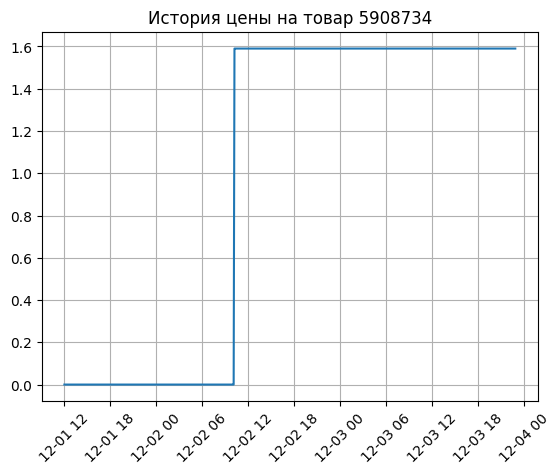

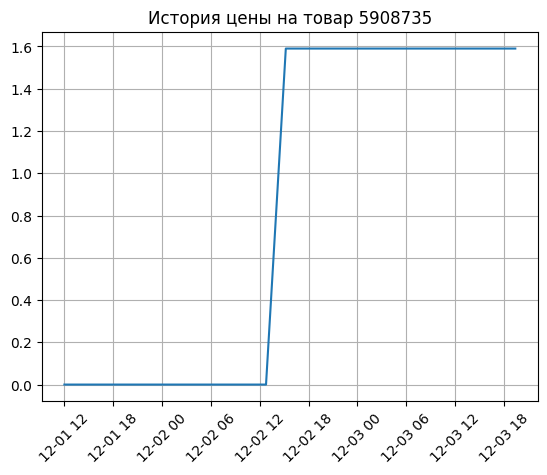

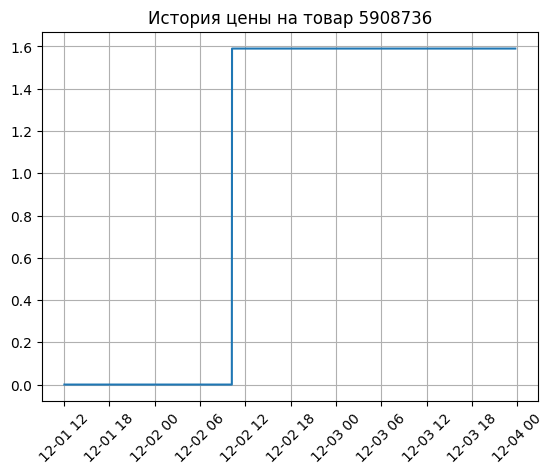

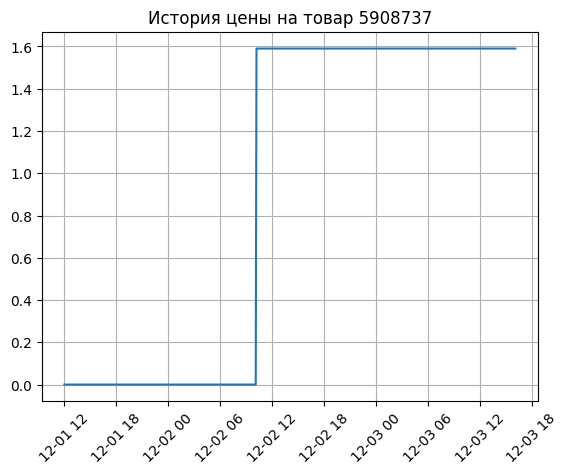

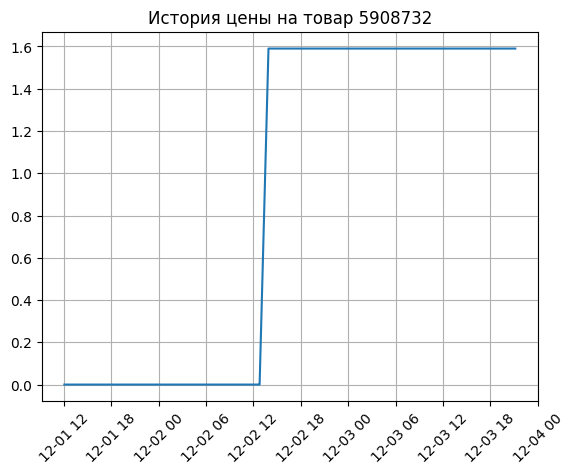

In [13]:
# Возможно, стоит посмотреть на зависимость некоторых товаров от времени
dataset['event_time'] = pd.to_datetime(dataset['event_time'])
for prod_id in not_enought_zero[10:15]:
	product_data = dataset[dataset['product_id'] == prod_id]
	plt.plot(product_data['event_time'], product_data['price'])
	plt.title(f"История цены на товар {prod_id}")
	plt.xticks(rotation=45)
	plt.grid(True)
	plt.show()

Важные инсайды из данных:
1) У товаров с `price=0` почти наверняка (98.7%) нет бренда и нет категорийного кода.
2) У части товаров с `price=0` цена изменилась в процессе, у другой части -- нет.
3) Товары без цены, возможно, просто закончились, поэтому не было событий с их покупкой.
4) У других товаров цена изменилась, они, возможно, просто появились/исчезли из продажи в течение месяца.

На основе этого можно попробовать сделать дополнительный признак -- наличие в продаже (`price=0`). На его основе точно можно будет сказать, какая вероятность того, что пользователь товар купит.

In [14]:
# Чистим данные, чтобы далее с ними было удобнее работать
dataset_clean = dataset.dropna(subset=["user_session"])
dataset_clean = dataset_clean.drop_duplicates()
dataset_clean = dataset_clean[dataset_clean["price"] >= 0] # убираем лишний мусор
dataset_clean['availability'] = dataset_clean["price"].map(lambda x: x > 0)
dataset_clean.fillna({
	"category_code": "unknown",
	"brand": "unknown",
	}, inplace=True)
dataset_clean.isna().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
availability     0
dtype: int64

In [15]:
# Смотрим, какие получились по итогу столбцы
dataset_clean.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 378030 entries, 0 to 399999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     378030 non-null  datetime64[ns, UTC]
 1   event_type     378030 non-null  object             
 2   product_id     378030 non-null  int64              
 3   category_id    378030 non-null  int64              
 4   category_code  378030 non-null  object             
 5   brand          378030 non-null  object             
 6   price          378030 non-null  float64            
 7   user_id        378030 non-null  int64              
 8   user_session   378030 non-null  object             
 9   availability   378030 non-null  bool               
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 120.1 MB


In [16]:
# Смотрим по каждому столбцу число уникальных значений
# Число пользователей, продуктов, категорий, брендов
dataset_clean.nunique()

event_time       173842
event_type            4
product_id        30783
category_id         437
category_code        11
brand               232
price              1651
user_id           49857
user_session      91665
availability          2
dtype: int64

## Анализ категорий товаров

Рассмотрим подробнее категории продуктов, сами продукты, их структуру, попытаемся достать полезную информацию оттуда.

In [17]:
# Сначала посмотрим на структуру `category_code`
dataset_clean['category_code'].value_counts()

category_code
unknown                                   371342
appliances.environment.vacuum               3258
apparel.glove                                837
stationery.cartrige                          822
furniture.living_room.cabinet                573
accessories.bag                              538
furniture.bathroom.bath                      480
appliances.personal.hair_cutter              104
accessories.cosmetic_bag                      57
appliances.environment.air_conditioner        14
furniture.living_room.chair                    5
Name: count, dtype: int64

In [18]:
# Посмотрим на процентное соотношение категорий
dataset_clean['category_code'].value_counts() / dataset_clean.shape[0] * 100

category_code
unknown                                   98.230828
appliances.environment.vacuum              0.861836
apparel.glove                              0.221411
stationery.cartrige                        0.217443
furniture.living_room.cabinet              0.151575
accessories.bag                            0.142317
furniture.bathroom.bath                    0.126974
appliances.personal.hair_cutter            0.027511
accessories.cosmetic_bag                   0.015078
appliances.environment.air_conditioner     0.003703
furniture.living_room.chair                0.001323
Name: count, dtype: float64

Ячейки с `category_code`, за исклочением `unknown` значений, имеют иерархическую структуру: сначала главная категория, а потом подкатегории. Видимо, этот столбец был создан для человекочитаемости, к какой категории товаров относится тот или иной `product_id`.

К сожалению, размеченных данных оказалось слишком мало (чуть больше 1%), поэтому этот столбец придётся в дальнейшем убрать, так как модель может переобучиться на этих малочисленных данных.

Но сначала нужно проверить гипотезу: а насколько хорошо соотносится `category_id` и `category_code`?

In [19]:
# Группируем данные по индексам
id_data = dataset_clean.groupby(['category_id'])

# Смотрим на то, могут ли одной `category_id` принадлежать несколько разных
# `category_code` (в идеале не должно быть)
non_consistent = 0
for cat_id, group in id_data:
    if len(group['category_code'].unique()) > 1:
        print(f"Для category_id {cat_id} нашлось несколько category_code: {group['category_code'].unique()}")
        non_consistent+=1

print(f"Все категории уникальные и их code и id соотносятся между собой")

Все категории уникальные и их code и id соотносятся между собой


Можно сделать вывод, что колонка `category_code` нам и не нужна, она дублирует функционал `category_id`, которых гораздо больше и они будут иметь явный смысл.

In [20]:
dataset_cat = dataset_clean.drop(["category_code"], axis=1)
dataset_cat.head(7)

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,availability
0,2019-12-01 00:00:00+00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,True
1,2019-12-01 00:00:00+00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,True
2,2019-12-01 00:00:02+00:00,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,True
3,2019-12-01 00:00:05+00:00,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,True
4,2019-12-01 00:00:07+00:00,view,5824148,1487580005511725929,unknown,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,True
5,2019-12-01 00:00:09+00:00,view,5773361,1487580005134238553,runail,2.62,560109803,38cf4ba1-4a0a-4c9e-b870-46685d105f95,True
6,2019-12-01 00:00:18+00:00,cart,5629988,1487580009311764506,unknown,1.19,579966747,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b,True


## Построение пайплайна обработки

Теперь нужно предобработать данные так, чтобы они подходили под обучение. Для этого требуется:
1) Сгрупиировать все данные по `session_id`, т.к. именно результаты каждой сессии мы и предсказываем
2) Внимательно отслеживать разные метрики отслеживания поведения пользователя: сколько раз смотрел товар, какие товары, как часто добавлял в корзину, насколько большая корзина выходит и так далее.
3) Потом сформировать таргет по ключевому признаку: `event_type == purchase`

Этот пайплайн дальше пойдёт в `ml_worker`, поэтому его надо отдельно сохранить, используя `joblib` и `Pipeline`.

In [21]:
# Предобработаем данные заранее, т.к. group_by долго работает
dataset_clean['view_price'] = np.where(dataset_clean['event_type'] == 'view', dataset_clean['price'], 0)
dataset_clean['cart_price'] = np.where(dataset_clean['event_type'] == 'cart', dataset_clean['price'], 0)

# Формируем сессии
dataset_analyze = dataset_clean.groupby('user_session').agg(
    view_count=('event_type', lambda x: (x == 'view').sum()),
    cart_count=('event_type', lambda x: (x == 'cart').sum()),
    remove_count=('event_type', lambda x: (x == 'remove_from_cart').sum()),
    total_view_value=('view_price', 'sum'),
    total_cart_value=('cart_price', 'sum'),
	# Внимание: ниже таргет
    is_purchased=('event_type', lambda x: int((x == 'purchase').any())),
	# А данный признак понадобится для разделения датасета на трейн и валидацию
    session_start=('event_time', 'min')
).reset_index()

print(f"Уникальных сессий: {dataset_analyze.shape[0]}")

Уникальных сессий: 91665


In [22]:
# Убедимся, что время в правильном формате
dataset_analyze['session_start'] = pd.to_datetime(dataset_analyze['session_start'])
dataset_analyze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91665 entries, 0 to 91664
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   user_session      91665 non-null  object             
 1   view_count        91665 non-null  int64              
 2   cart_count        91665 non-null  int64              
 3   remove_count      91665 non-null  int64              
 4   total_view_value  91665 non-null  float64            
 5   total_cart_value  91665 non-null  float64            
 6   is_purchased      91665 non-null  int64              
 7   session_start     91665 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), int64(4), object(1)
memory usage: 5.6+ MB


In [23]:
# Находим точку отсечения (последние 7 дней месяца)
split_index = int(len(dataset_analyze) * 0.7)
split_index

64165

In [24]:
# Бьем на выборки
train_df = dataset_analyze[:split_index]
val_df = dataset_analyze[split_index:]
train_df.shape, val_df.shape

((64165, 8), (27500, 8))

In [25]:
# Разбиваем датасет на признаки и таргет
features = ['view_count', 'cart_count', 'remove_count', 'total_view_value', 'total_cart_value']

X_train = train_df[features]
y_train = train_df['is_purchased']
X_val = val_df[features]
y_val = val_df['is_purchased']

print(f"Тренировочная выборка: {X_train.shape[0]} сессий")
print(f"Валидационная выборка: {X_val.shape[0]} сессий")
print(f"Доля покупко: {y_train.mean() * 100:.2f}%")

Тренировочная выборка: 64165 сессий
Валидационная выборка: 27500 сессий
Доля покупко: 3.11%


Так как конверсия низкая, её надо заранее учесть. У нас явно выраженный дисбаланс классов, поэтому стоит при обучении использовать параметр `auto_class_weights='Balanced'`, иначе классификатор переобучится на 0-ом классе.

In [26]:
# Готовый пайплайн
ml_pipeline = Pipeline([
    ('classifier', CatBoostClassifier(
        iterations=300,
        learning_rate=0.1,
        depth=5,
        eval_metric='AUC',
        auto_class_weights='Balanced',
        random_seed=42,
        verbose=50
    ))
])

In [27]:
# Обучаем
ml_pipeline.fit(
    X_train, y_train,
    classifier__eval_set=(X_val, y_val),
    classifier__early_stopping_rounds=50,
)

0:	test: 0.9325356	best: 0.9325356 (0)	total: 50.3ms	remaining: 15s
50:	test: 0.9360969	best: 0.9360969 (50)	total: 319ms	remaining: 1.56s
100:	test: 0.9358045	best: 0.9361865 (58)	total: 709ms	remaining: 1.4s
150:	test: 0.9347848	best: 0.9362289 (108)	total: 1.11s	remaining: 1.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9362288736
bestIteration = 108

Shrink model to first 109 iterations.


,steps,"[('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False


Получилась очень хорошая точность на метрике AUC, 93.5%.

Можно использовать в пайплайне.

In [28]:
os.makedirs('models', exist_ok=True)
model_path = 'models/pipeline.pkl'
joblib.dump(ml_pipeline, model_path)

['models/pipeline.pkl']